In [302]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/germandata1/german.data
/kaggle/input/germandata/german.data
/kaggle/input/uci-credit-approval/crx.csv


In [303]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
import xgboost as xgb  # XGBoost stuff
from sklearn.model_selection import train_test_split  # Split data into training and testing sets
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    make_scorer,
    confusion_matrix,
)  # For scoring during model evaluation
from sklearn.model_selection import GridSearchCV  # Grid search for hyperparameter tuning


In [305]:
file = '/kaggle/input/germandata1/german.data'
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
df = pd.read_csv(file, names=names, delimiter='\t')
df.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


# No missing values

In [306]:
df.isnull().sum()

existingchecking         0
duration                 0
credithistory            0
purpose                  0
creditamount             0
savings                  0
employmentsince          0
installmentrate          0
statussex                0
otherdebtors             0
residencesince           0
property                 0
age                      0
otherinstallmentplans    0
housing                  0
existingcredits          0
job                      0
peopleliable             0
telephone                0
foreignworker            0
classification           0
dtype: int64

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   existingchecking       1000 non-null   object
 1   duration               1000 non-null   int64 
 2   credithistory          1000 non-null   object
 3   purpose                1000 non-null   object
 4   creditamount           1000 non-null   int64 
 5   savings                1000 non-null   object
 6   employmentsince        1000 non-null   object
 7   installmentrate        1000 non-null   int64 
 8   statussex              1000 non-null   object
 9   otherdebtors           1000 non-null   object
 10  residencesince         1000 non-null   int64 
 11  property               1000 non-null   object
 12  age                    1000 non-null   int64 
 13  otherinstallmentplans  1000 non-null   object
 14  housing                1000 non-null   object
 15  existingcredits       

In [308]:
df.replace([1,2], [1,0], inplace=True)
df.classification.value_counts()

classification
1    700
0    300
Name: count, dtype: int64

## In this data all the continuous variables have slightly skewed distribution, which is acceptable, hence no outlier treatment is required

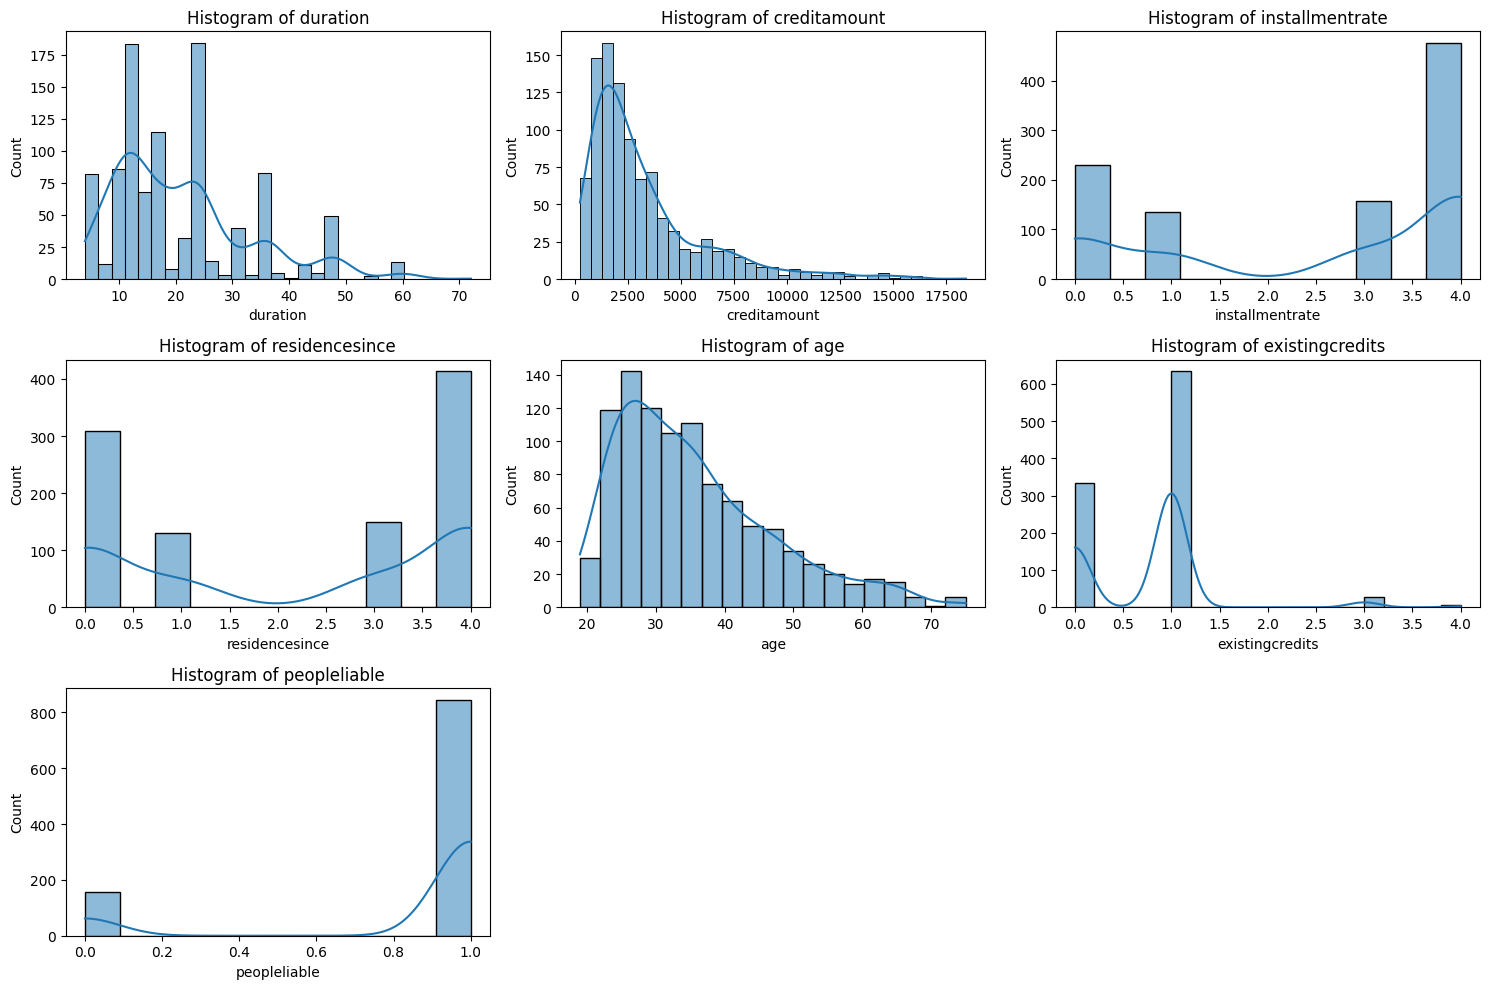

In [309]:
continuous_columns = ['duration', 'creditamount', 'installmentrate', 'residencesince', 'age', 'existingcredits', 'peopleliable']

# Plot histograms for each continuous variable
plt.figure(figsize=(15, 10))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()


In [310]:
df2=df.copy()

In [311]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   existingchecking       1000 non-null   object
 1   duration               1000 non-null   int64 
 2   credithistory          1000 non-null   object
 3   purpose                1000 non-null   object
 4   creditamount           1000 non-null   int64 
 5   savings                1000 non-null   object
 6   employmentsince        1000 non-null   object
 7   installmentrate        1000 non-null   int64 
 8   statussex              1000 non-null   object
 9   otherdebtors           1000 non-null   object
 10  residencesince         1000 non-null   int64 
 11  property               1000 non-null   object
 12  age                    1000 non-null   int64 
 13  otherinstallmentplans  1000 non-null   object
 14  housing                1000 non-null   object
 15  existingcredits       

In [312]:
from sklearn.model_selection import train_test_split

X, y = df2.drop('classification', axis=1), df2[['classification']]

In [313]:
X.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,residencesince,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,0,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,0,A92,A101,0,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,0,A93,A101,3,A121,49,A143,A152,1,A172,0,A191,A201
3,A11,42,A32,A42,7882,A61,A74,0,A93,A103,4,A122,45,A143,A153,1,A173,0,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,0,A173,0,A191,A201


## Now categorical to numerical using Label Encoding


In [314]:
categorical_mappings = {
    'existingchecking': {'A11': 1, 'A12': 2, 'A13': 3, 'A14': 4},
    'credithistory': {'A30': 1, 'A31': 2, 'A32': 3, 'A33': 4, 'A34': 5},
    'purpose': {'A40': 1, 'A41': 2, 'A42': 3, 'A43': 4, 'A44': 5, 'A45': 6, 'A46': 7, 'A47': 8, 'A48': 9, 'A49': 10, 'A410': 11},
    'savings': {'A61': 1, 'A62': 2, 'A63': 3, 'A64': 4, 'A65': 5},
    'employmentsince': {'A71': 1, 'A72': 2, 'A73': 3, 'A74': 4, 'A75': 5},
    'statussex': {'A91': 1, 'A92': 2, 'A93': 3, 'A94': 4, 'A95': 5},
    'otherdebtors': {'A101': 1, 'A102': 2, 'A103': 3},
    'property': {'A121': 1, 'A122': 2, 'A123': 3, 'A124': 4},
    'otherinstallmentplans': {'A141': 1, 'A142': 2, 'A143': 3},
    'housing': {'A151': 1, 'A152': 2, 'A153': 3},
    'job': {'A171': 1, 'A172': 2, 'A173': 3, 'A174': 4},
    'telephone': {'A191': 1, 'A192': 2},
    'foreignworker': {'A201': 1, 'A202': 2}
}

# Apply the mappings to the respective columns
X.replace(categorical_mappings, inplace=True)

In [315]:
X.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,residencesince,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker
0,1,6,5,4,1169,5,5,4,3,1,4,1,67,3,2,0,3,1,2,1
1,2,48,3,4,5951,1,3,0,2,1,0,1,22,3,2,1,3,1,1,1
2,4,12,5,7,2096,1,4,0,3,1,3,1,49,3,2,1,2,0,1,1
3,1,42,3,3,7882,1,4,0,3,3,4,2,45,3,3,1,3,0,1,1
4,1,24,4,1,4870,1,3,3,3,1,4,4,53,3,3,0,3,0,1,1


In [316]:
np.mean(y)

0.7

In [317]:
# Split the data stratified
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42,stratify=y)

In [318]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 80 to 964
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   classification  300 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


In [319]:
np.mean(y_train)

0.7

In [320]:
np.mean(y_test)

0.7

In [321]:
from xgboost import XGBClassifier

In [322]:
clf=XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, objective='binary:logistic', booster='gbtree')
print(clf)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [323]:
# clf_xgb = xgb.XGBClassifier(
#     objective='binary:logistic',
#     missing=0,
#     seed=42,
#     eval_metric='auc',
#     early_stopping_rounds=10
# )

# clf_xgb.fit(
#     X_train,
#     y_train,
#     verbose=True,
#     eval_set=[(X_test, y_test)]
# )

In [324]:
XGB=clf.fit(X_train,y_train)
y_pred=XGB.predict(X_test)

In [325]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, y_pred, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

              precision    recall  f1-score   support

           0       0.65      0.33      0.44        90
           1       0.76      0.92      0.84       210

    accuracy                           0.75       300
   macro avg       0.71      0.63      0.64       300
weighted avg       0.73      0.75      0.72       300

[[ 30  60]
 [ 16 194]]
Accuracy of the model on Testing Sample Data: 0.72


In [326]:
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(XGB, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.77781287 0.70181818 0.7547619  0.72867133 0.73104474 0.74796273
 0.75652174 0.77781287 0.77781287 0.73104474]

Final Average Accuracy of the model: 0.75


In [327]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 800x600 with 0 Axes>

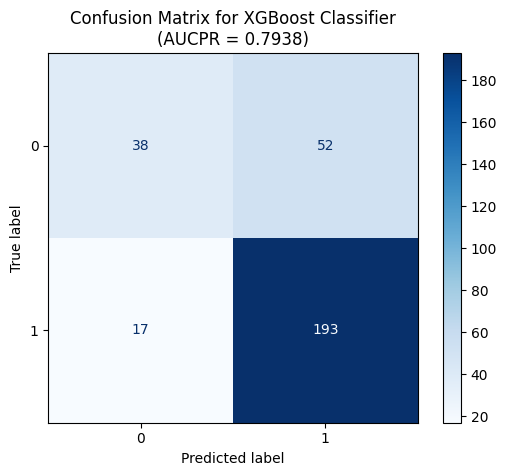

In [328]:
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xgb.classes_)
plt.figure(figsize=(8, 6))  
disp.plot(cmap=plt.cm.Blues,  
          values_format='d', 
          include_values=True,  
          xticks_rotation='horizontal') 
plt.title("Confusion Matrix for XGBoost Classifier\n(AUCPR = {})".format(round(clf_xgb.best_score, 4))) 
plt.show()

In [329]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 77.00%


In [330]:
from sklearn.metrics import roc_curve, auc

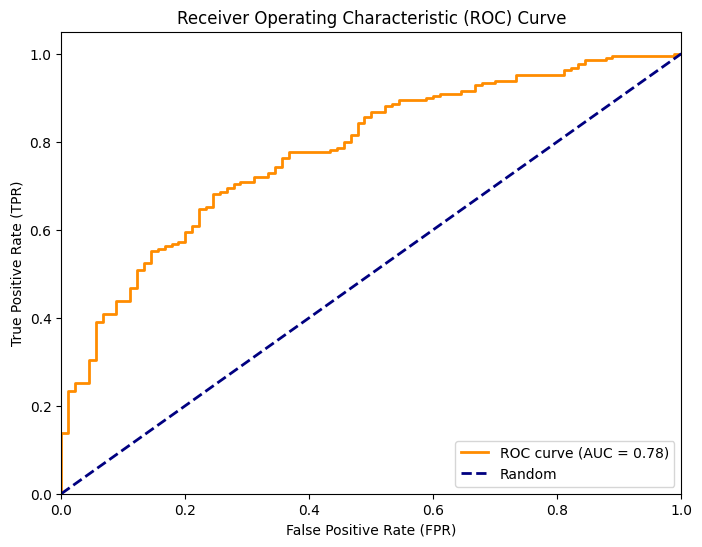

In [331]:
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Testing my dataset on Hemanth created model RandomForestClassifier

In [332]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [333]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


Random Forest Confusion Matrix:
[[ 30  30]
 [ 16 124]]


<Figure size 800x600 with 0 Axes>

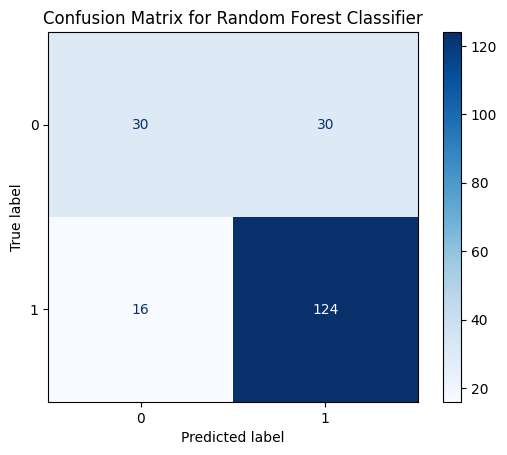

In [334]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
print('Random Forest Confusion Matrix:')
print(cm_rf)

# Plot Confusion Matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)
plt.figure(figsize=(8, 6))
disp_rf.plot(cmap=plt.cm.Blues, values_format='d', include_values=True, xticks_rotation='horizontal')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

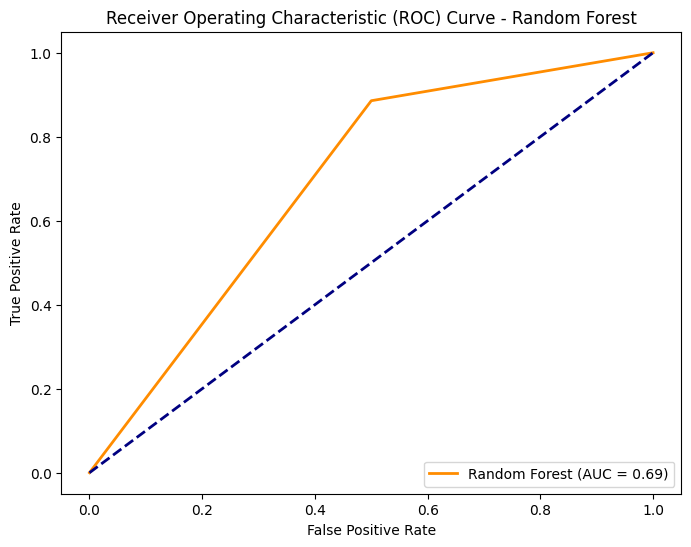

In [335]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve for Random Forest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()




In [336]:
from sklearn.svm import SVC

In [337]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Accuracy: 0.74
SVM Confusion Matrix:
[[ 36  24]
 [ 28 112]]


<Figure size 800x600 with 0 Axes>

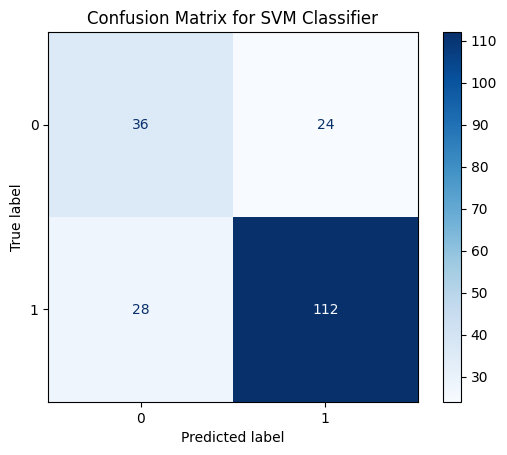

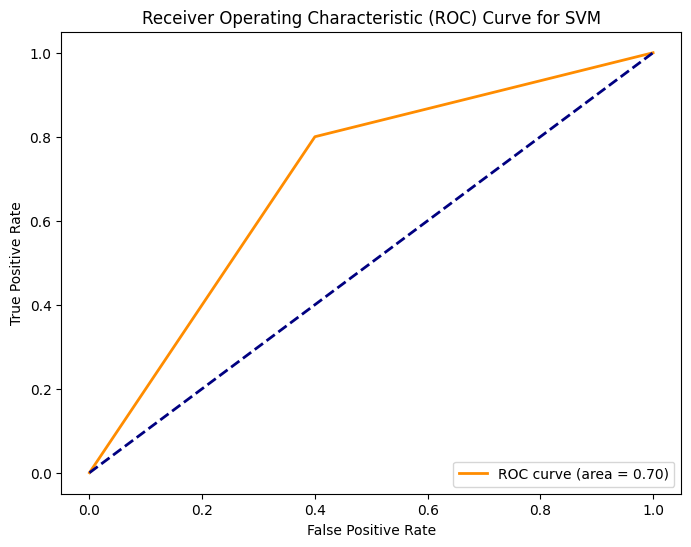

In [338]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the model
svm_classifier.fit(X_train_svm, y_train_svm.values.ravel())

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test_svm)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"Accuracy: {accuracy_svm:.2f}")

cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
print('SVM Confusion Matrix:')
print(cm_svm)

# Plot Confusion Matrix for SVM
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_classifier.classes_)
plt.figure(figsize=(8, 6))
disp_svm.plot(cmap=plt.cm.Blues, values_format='d', include_values=True, xticks_rotation='horizontal')
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

# Calculate ROC curve and AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_svm, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc='lower right')
plt.show()

# NAIVE BAYES

In [339]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

Accuracy: 0.70
Naive Bayes Confusion Matrix:
[[ 40  20]
 [ 40 100]]


<Figure size 800x600 with 0 Axes>

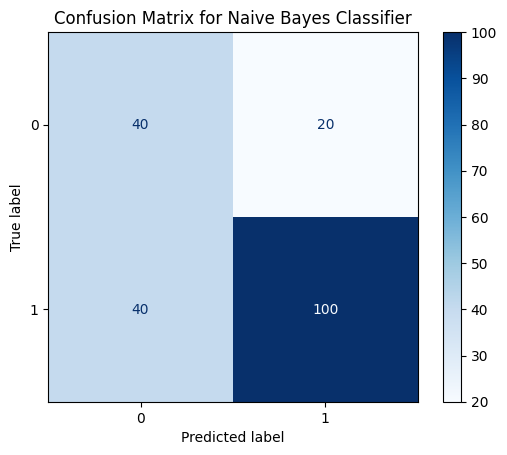

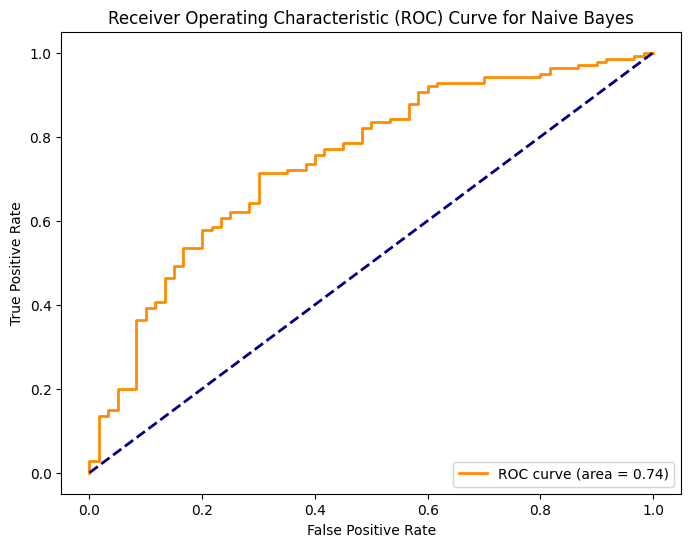

In [340]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Gaussian Naive Bayes Classifier
nb_classifier = GaussianNB()

# Train the model
nb_classifier.fit(X_train_nb, y_train_nb.values.ravel())

# Make predictions on the test set
y_pred_nb = nb_classifier.predict(X_test_nb)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
print(f"Accuracy: {accuracy_nb:.2f}")

cm_nb = confusion_matrix(y_test_nb, y_pred_nb)
print('Naive Bayes Confusion Matrix:')
print(cm_nb)

# Plot Confusion Matrix for Naive Bayes
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_classifier.classes_)
plt.figure(figsize=(8, 6))
disp_nb.plot(cmap=plt.cm.Blues, values_format='d', include_values=True, xticks_rotation='horizontal')
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

# Calculate ROC curve and AUC using decision_function
y_pred_nb = nb_classifier.predict_proba(X_test_nb)[:, 1]  # Using the positive class probability as decision pred

fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_nb, y_pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

# ROC curve for all classification models used

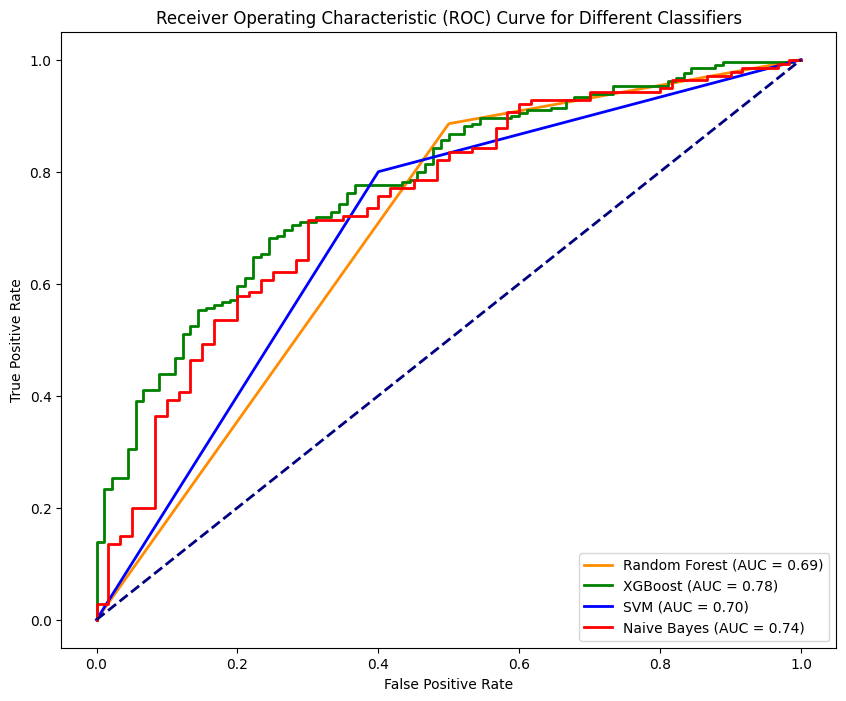

In [341]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr, tpr, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_nb, tpr_nb, color='red', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Different Classifiers')
plt.legend(loc='lower right')
plt.show()

# This are the accuracy estimation given in UCI website for this model

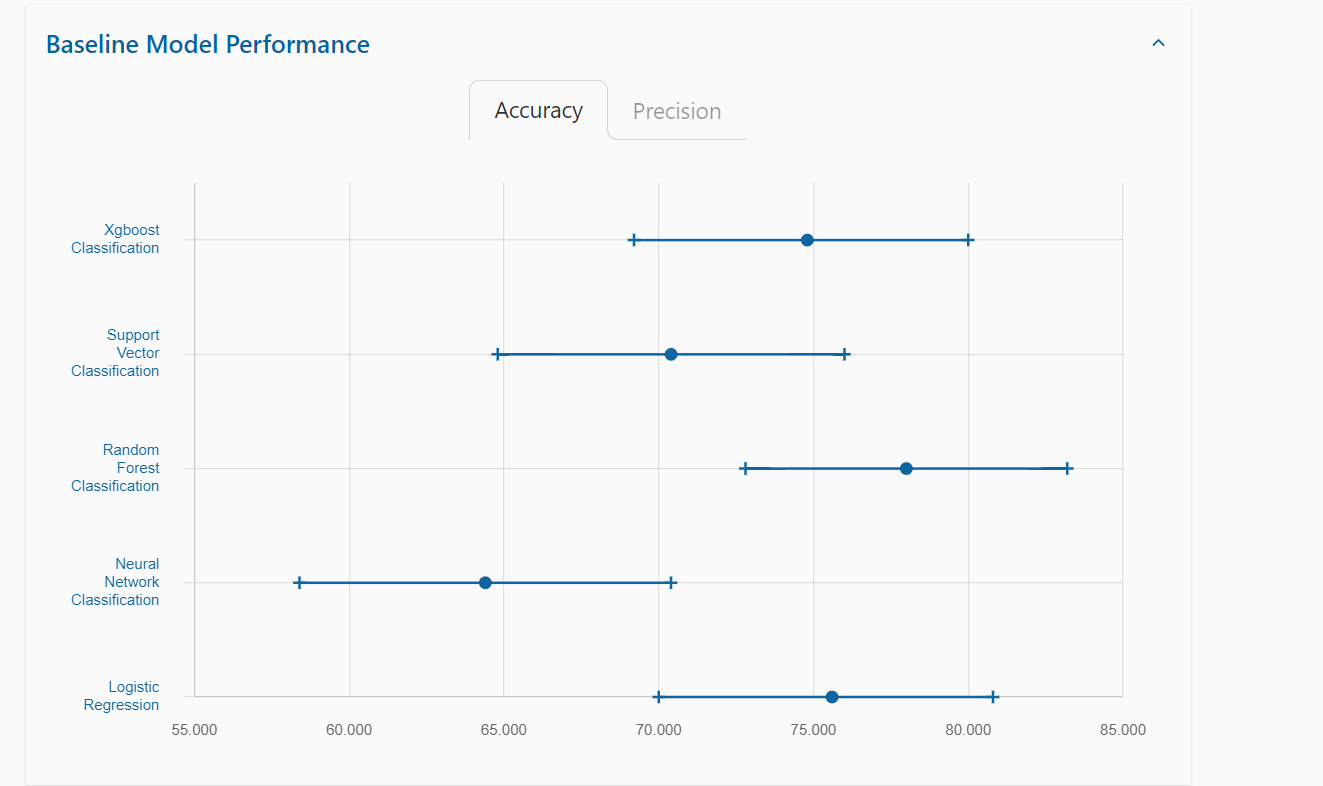